In [20]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
# Load dataset
df = pd.read_csv('training_1600000_processed_noemoticon.csv', encoding='ISO-8859-1', names=DATASET_COLUMNS)

In [3]:
print('Dataset Size: ', len(df))

Dataset Size:  1600000


In [4]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
# Map target label to String
decode_map = {0:'Negative', 2:'Neutral', 4:'Positive'}
def decode_sentiment(label):
    return decode_map[int(label)]

In [6]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: total: 203 ms
Wall time: 377 ms


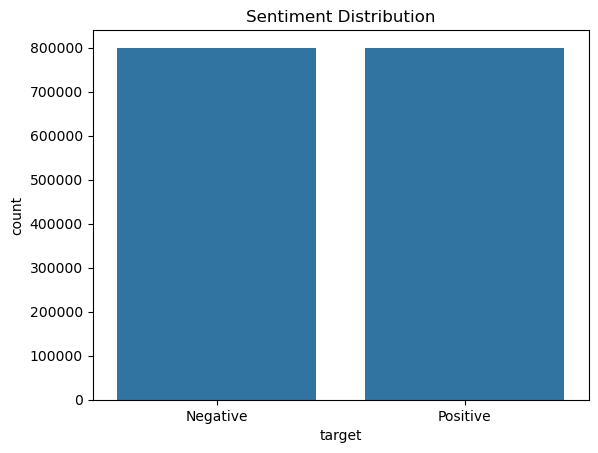

In [7]:
sns.countplot(x='target', data=df)
plt.title('Sentiment Distribution')
plt.show()

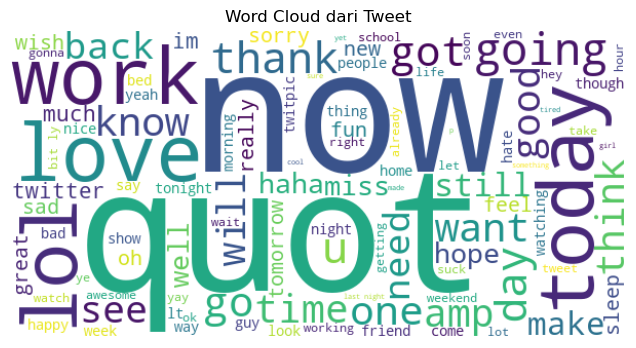

In [8]:
sample_tweets = df['text'].sample(frac=0.1)  # 10% sampling
all_tweets = ' '.join(sample_tweets)

wordcloud = WordCloud(width=600, height=300, background_color='white', max_words=100).generate(all_tweets)

plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Tweet')
plt.show()

In [9]:
# Text cleaning
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    return text

df['cleaned_text'] = df['text'].apply(preprocess_text)

In [10]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
word_index = tokenizer.word_index
X = pad_sequences(sequences, maxlen=100)
y = df['target'].values

In [11]:
# Load pre-trained GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

C:\Users\yusuf\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [15]:
# Initialized LabelEncoder
label_encoder = LabelEncoder()

# Convert y_train and y_test to numeric
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [16]:
# Train the model
history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 2109s 66ms/step - accuracy: 0.7678 - loss: 0.4776 - val_accuracy: 0.8116 - val_loss: 0.4091
Epoch 2/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 2094s 65ms/step - accuracy: 0.8177 - loss: 0.3995 - val_accuracy: 0.8214 - val_loss: 0.3936
Epoch 3/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 2169s 68ms/step - accuracy: 0.8289 - loss: 0.3797 - val_accuracy: 0.8248 - val_loss: 0.3884
Epoch 4/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 3911s 122ms/step - accuracy: 0.8355 - loss: 0.3680 - val_accuracy: 0.8251 - val_loss: 0.3889
Epoch 5/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 8864s 277ms/step - accuracy: 0.8403 - loss: 0.3588 - val_accuracy: 0.8260 - val_loss: 0.3946
Epoch 6/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 2319s 72ms/step - accuracy: 0.8450 - loss: 0.3499 - val_accuracy: 0.8257 - val_loss: 0.3916


In [18]:
# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test_encoded, y_pred))

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 224s 22ms/step
Accuracy: 0.8255
              precision    recall  f1-score   support

           0       0.81      0.84      0.83    159494
           1       0.84      0.81      0.82    160506

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000



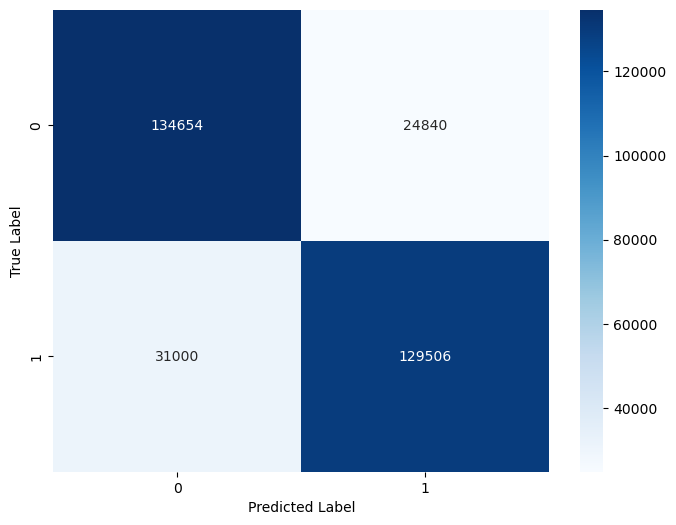

In [21]:
# Result Visualization
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()